### L17-Demo

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

/Users/jamiew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


To explore time series models, we will continue with the Rossmann sales data. This dataset has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.

In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time. Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day? week? month?

/Users/jamiew/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


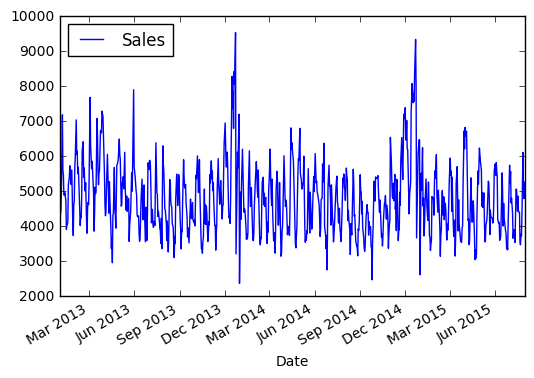

In [3]:
import pandas as pd

# Load the data and set the DateTime index
data = pd.read_csv('rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

# Plot the sales over time
store1_open_data[['Sales']].plot()

In [4]:
store1_open_data.head() #note that the store isn't open every day - not autocorrelated if you have a lot of zeros
#in ur dataset. Sundays in a business week will throw things off

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [5]:
store1_data.Sales.autocorr(lag=1) # -0.12

-0.12732514339140213

In [6]:
store1_data.Sales.autocorr(lag=2) # -0.03

-0.034787155707946944

^^ still very autocorrelated

Pandas and statsmodels both provide convenience plots for autocorrelations.

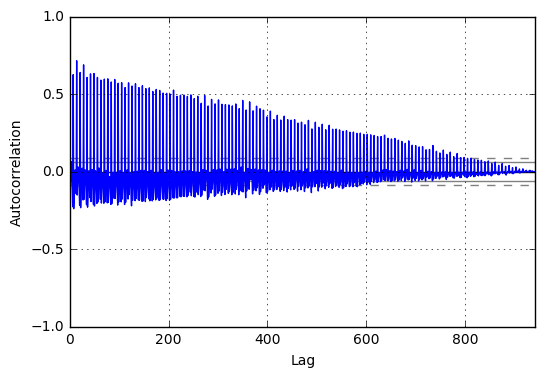

In [7]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_data.Sales)

^^ can see we're going far back but there is some degree of autocorrelation that's broken apart (strange) and also some __ data

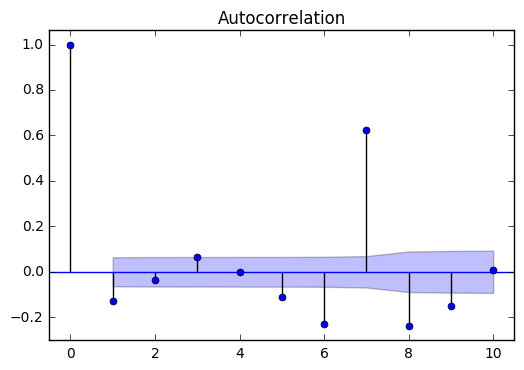

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_data.Sales, lags=10)
plt.show()

y axis is autocorrelation. Since python is 0 index, 100% correlated with itself. going along, not a lot of correlation 
until you hit 7. This includes all the data even when it's closed. So, what's happening is its the same day of the week. You'll see a lot of this kind of thing- first Monday of the month, etc. 

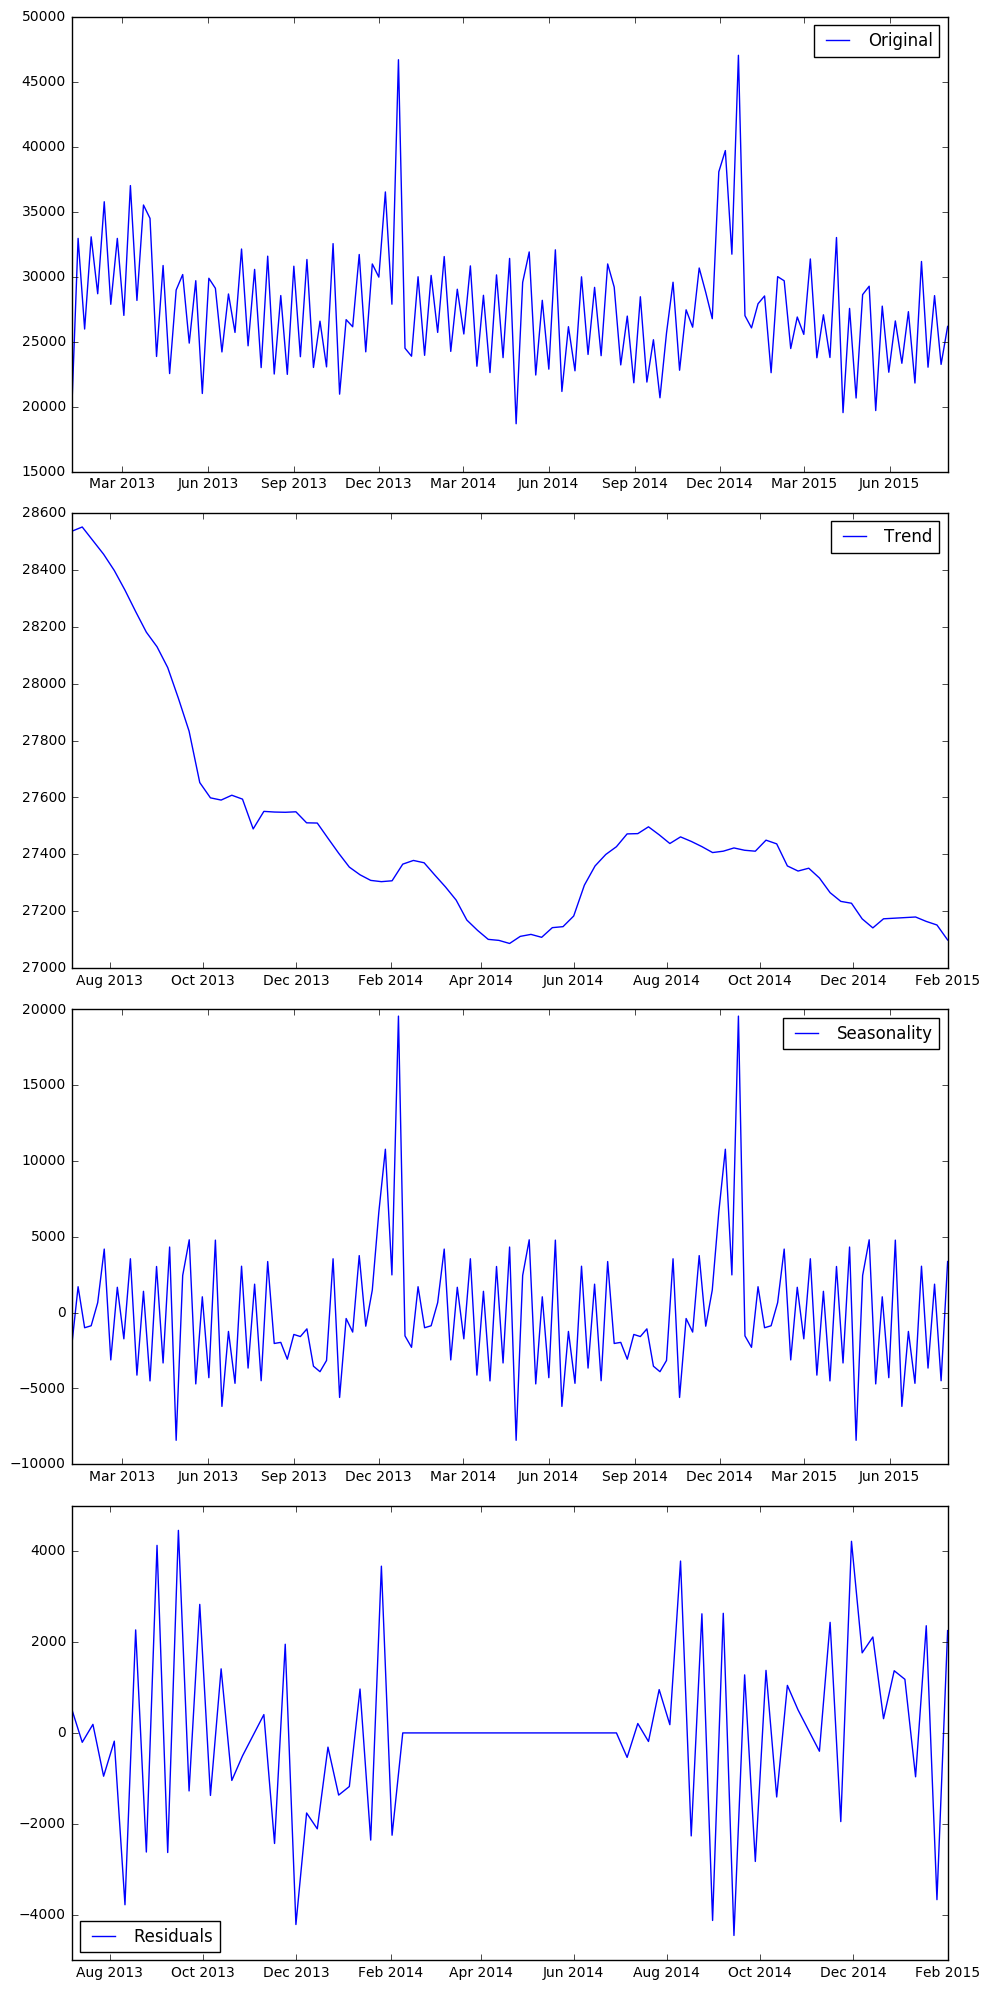

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily = store1_open_data[['Sales']]

weekly_opendays = store1_data['Sales'].resample("W").sum()

X = weekly_opendays


#decomposition = seasonal_decompose(store1_data['Sales'])

decomposition = seasonal_decompose(X)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(10, 20)) 


plt.subplot(411)
plt.plot(X, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
X

Date
2013-01-06    19340
2013-01-13    32952
2013-01-20    25978
2013-01-27    33071
2013-02-03    28693
2013-02-10    35771
2013-02-17    27880
2013-02-24    32951
2013-03-03    27027
2013-03-10    37016
2013-03-17    28179
2013-03-24    35521
2013-03-31    34492
2013-04-07    23867
2013-04-14    30865
2013-04-21    22552
2013-04-28    28979
2013-05-05    30171
2013-05-12    24895
2013-05-19    29696
2013-05-26    21018
2013-06-02    29884
2013-06-09    29112
2013-06-16    24215
2013-06-23    28675
2013-06-30    25716
2013-07-07    32134
2013-07-14    24687
2013-07-21    30566
2013-07-28    23010
              ...  
2015-01-11    27922
2015-01-18    28522
2015-01-25    22618
2015-02-01    30008
2015-02-08    29690
2015-02-15    24477
2015-02-22    26902
2015-03-01    25566
2015-03-08    31369
2015-03-15    23767
2015-03-22    27073
2015-03-29    23788
2015-04-05    33019
2015-04-12    19546
2015-04-19    27563
2015-04-26    20670
2015-05-03    28627
2015-05-10    29272
2015-05-17    1

**Check**: What caused the spike at 7?

# ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model. 

In [11]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)

X1 = X.to_frame().astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Tue, 11 Apr 2017   AIC                          12540.651
Time:                        20:23:59   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4761.9579     82.984     57.384      0.000    4599.312    4924.604
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots       

In [12]:
model = ARMA(store1_sales_data, (2, 0)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Tue, 11 Apr 2017   AIC                          12542.063
Time:                        20:23:59   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.3980     85.262     55.856      0.000    4595.287    4929.509
ar.L1.Sales     0.6634      0.036     18.537      0.000       0.593       0.734
ar.L2.Sales     0.0275      0.036      0.767    

Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

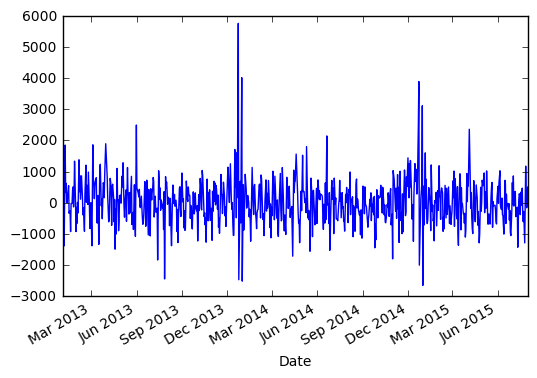

In [13]:
model.resid.plot()

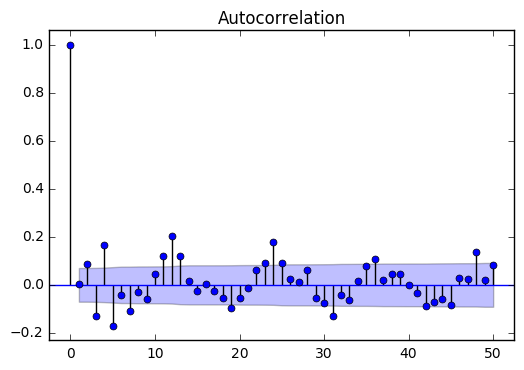

In [14]:
plot_acf(model.resid, lags=50)
plt.show()

Because of the errors, it doesn't look like an AR model is good enough -- the data aren't stationary. So let's expand to an `ARMA` model.

In [15]:
model = ARMA(store1_sales_data, (1, 1)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Tue, 11 Apr 2017   AIC                          12542.222
Time:                        20:24:00   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.7628     84.702     56.229      0.000    4596.749    4928.776
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654    

In [16]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (2, 0, 2)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 2)   Log Likelihood               -6243.725
Method:                       css-mle   S.D. of innovations            716.957
Date:                Tue, 11 Apr 2017   AIC                          12499.449
Time:                        20:24:00   BIC                          12527.413
Sample:                    07-31-2015   HQIC                         12510.204
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4760.9231     75.652     62.932      0.000    4612.649    4909.197
ar.L1.Sales    -0.2277      0.056     -4.064      0.000      -0.338      -0.118
ar.L2.Sales     0.4689      0.057      8.271    

In [17]:
model = ARIMA(store1_sales_data, (2, 1, 2)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6247.179
Method:                       css-mle   S.D. of innovations            725.652
Date:                Tue, 11 Apr 2017   AIC                          12506.358
Time:                        20:24:01   BIC                          12534.314
Sample:                    07-30-2015   HQIC                         12517.111
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5079      0.387      1.313      0.189      -0.250       1.266
ar.L1.D.Sales    -0.1820      0.050     -3.661      0.000      -0.279      -0.085
ar.L2.D.Sales     0.6469      0.035     

In [18]:
model = ARIMA(store1_sales_data, (2, 1, 0)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6313.493
Method:                       css-mle   S.D. of innovations            792.554
Date:                Tue, 11 Apr 2017   AIC                          12634.985
Time:                        20:24:01   BIC                          12653.622
Sample:                    07-30-2015   HQIC                         12642.153
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1303     23.604      0.006      0.996     -46.133      46.393
ar.L1.D.Sales    -0.1847      0.036     -5.155      0.000      -0.255      -0.114
ar.L2.D.Sales    -0.0178      0.036     

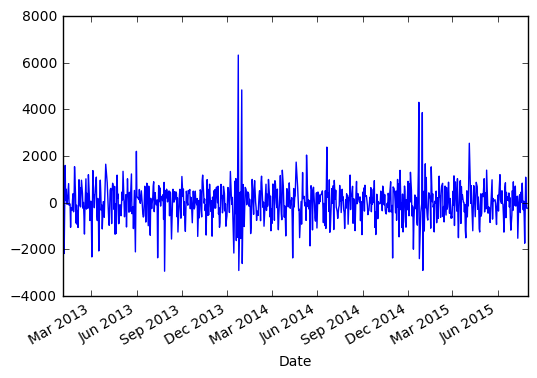

In [19]:
store1_sales_data.Sales.diff(1).autocorr(1) #-0.181

store1_sales_data.Sales.diff(1).plot()
plt.show()

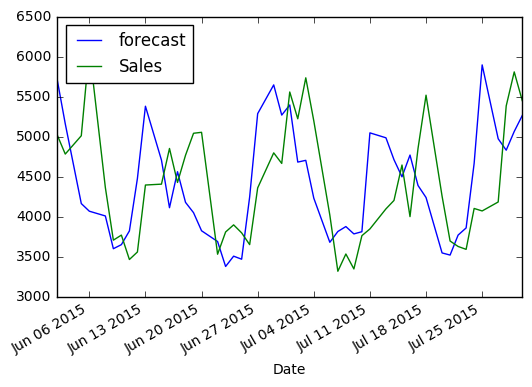

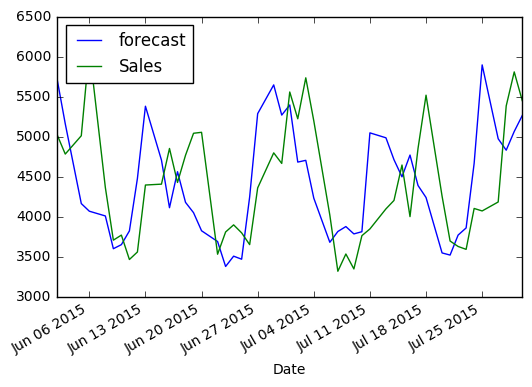

In [20]:
model.plot_predict(1, 50)

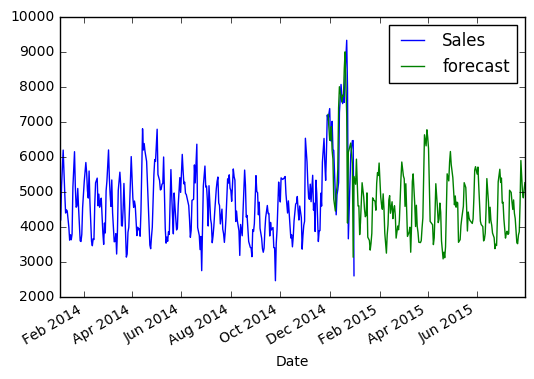

In [21]:
fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

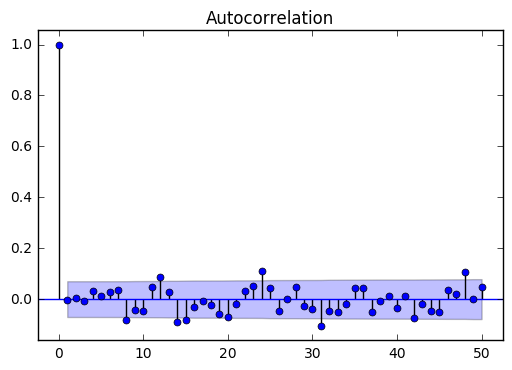

In [22]:
model = ARIMA(store1_sales_data, (7, 1, 2)).fit()
model.summary()

plot_acf(model.resid, lags=50)
plt.show()